<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/PatchCore_timm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =====================================================
# セル1: MVTec AD を mydrive 直リンクからダウンロード＆展開（Drive不要）
# - TARGET="all" なら全体 (~5GB)
# - それ以外はクラス名（例: "bottle"）のみをダウンロード
# - 展開先: /content/mvtec_anomaly_detection/<class>/...
# - 互換リンク: /content/mvtec -> /content/mvtec_anomaly_detection
# =====================================================

import os, subprocess, tarfile, zipfile, glob

TARGET = "bottle"  # "all" または 15クラス名のいずれか: bottle,cable,capsule,carpet,grid,hazelnut,leather,metal_nut,pill,screw,tile,toothbrush,transistor,wood,zipper
DEST_PARENT = "/content"
DEST_ROOT   = os.path.join(DEST_PARENT, "mvtec_anomaly_detection")
COMP_LINK   = "/content/mvtec"  # 互換リンク

WHOLE_URL = "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938113-1629952094/mvtec_anomaly_detection.tar.xz"
CLASS_URLS = {
    "bottle":      "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937370-1629951468/bottle.tar.xz",
    "cable":       "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937413-1629951498/cable.tar.xz",
    "capsule":     "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937454-1629951595/capsule.tar.xz",
    "carpet":      "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937484-1629951672/carpet.tar.xz",
    "grid":        "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937487-1629951814/grid.tar.xz",
    "hazelnut":    "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937545-1629951845/hazelnut.tar.xz",
    "leather":     "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937607-1629951964/leather.tar.xz",
    "metal_nut":   "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937637-1629952063/metal_nut.tar.xz",
    "pill":        "https://www.mydrive.ch/shares/43421/11a215a5749fcfb75e331ddd5f8e43ee/download/420938129-1629953099/pill.tar.xz",
    "screw":       "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938130-1629953152/screw.tar.xz",
    "tile":        "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938133-1629953189/tile.tar.xz",
    "toothbrush":  "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938134-1629953256/toothbrush.tar.xz",
    "transistor":  "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938166-1629953277/transistor.tar.xz",
    "wood":        "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938383-1629953354/wood.tar.xz",
    "zipper":      "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938385-1629953449/zipper.tar.xz",
}
IMG_EXTS = ('*.png','*.jpg','*.jpeg','*.bmp','*.tif','*.tiff')

def run(cmd):
    print("[RUN]", cmd)
    rc = subprocess.call(cmd, shell=True)
    if rc != 0:
        raise RuntimeError(f"Command failed (rc={rc}): {cmd}")

def list_images_multi_ext(dirpath: str):
    files=[]
    for ext in IMG_EXTS:
        files += glob.glob(os.path.join(dirpath, '**', ext), recursive=True)
    return sorted(files)

os.makedirs(DEST_ROOT, exist_ok=True)

if TARGET == "all":
    tar_path = os.path.join(DEST_PARENT, "mvtec_ad.tar.xz")
    run(f'wget --progress=dot:mega -O "{tar_path}" "{WHOLE_URL}"')
    run(f'tar -xf "{tar_path}" -C "{DEST_PARENT}"')
else:
    if TARGET not in CLASS_URLS:
        raise ValueError(f"Unknown TARGET='{TARGET}'.")
    tar_path = os.path.join(DEST_PARENT, f"{TARGET}.tar.xz")
    run(f'wget --progress=dot:mega -O "{tar_path}" "{CLASS_URLS[TARGET]}"')
    run(f'tar -xf "{tar_path}" -C "{DEST_ROOT}"')

# 互換リンク（/content/mvtec）が無ければ作成
if not os.path.exists(COMP_LINK):
    try:
        os.symlink(DEST_ROOT, COMP_LINK)
        print("[INFO] Symlink:", COMP_LINK, "->", DEST_ROOT)
    except Exception as e:
        print("[WARN] symlink failed:", e)

# 簡易チェック＆要約
def quick_summary(root_parent="/content"):
    candidates = ["/content/mvtec", "/content/mvtec_anomaly_detection"]
    ok = False
    for base in candidates:
        if not os.path.isdir(base): continue
        classes = [d for d in os.listdir(base) if os.path.isdir(os.path.join(base, d))]
        classes = sorted([c for c in classes if os.path.isdir(os.path.join(base,c,"test")) or os.path.isdir(os.path.join(base,c,"train"))])
        if not classes: continue
        print(f"[READY] Found classes under {base}: {classes[:10]}{' ...' if len(classes)>10 else ''}")
        # 1クラスだけ簡易枚数
        cls0 = classes[0]
        tg = os.path.join(base, cls0, "train", "good")
        ttg= os.path.join(base, cls0, "test",  "good")
        n_tg = len(list_images_multi_ext(tg)) if os.path.isdir(tg) else 0
        n_ttg= len(list_images_multi_ext(ttg)) if os.path.isdir(ttg) else 0
        print(f"[SUMMARY] sample class={cls0}: train/good={n_tg}, test/good={n_ttg}")
        ok = True
    if not ok:
        raise FileNotFoundError("Extraction finished but dataset layout not detected. Please check archive.")
    print("[DONE] MVTec AD is ready under /content/mvtec_anomaly_detection")

quick_summary()


[RUN] wget --progress=dot:mega -O "/content/bottle.tar.xz" "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937370-1629951468/bottle.tar.xz"
[RUN] tar -xf "/content/bottle.tar.xz" -C "/content/mvtec_anomaly_detection"
[INFO] Symlink: /content/mvtec -> /content/mvtec_anomaly_detection
[READY] Found classes under /content/mvtec: ['bottle']
[SUMMARY] sample class=bottle: train/good=209, test/good=20
[READY] Found classes under /content/mvtec_anomaly_detection: ['bottle']
[SUMMARY] sample class=bottle: train/good=209, test/good=20
[DONE] MVTec AD is ready under /content/mvtec_anomaly_detection


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

[SUMMARY] {'root': '/content/mvtec', 'class': 'bottle', 'train/good': 209, 'test/good': 20, 'test/anoms': 63, 'anomaly_types': ['contamination', 'broken_large', 'broken_small']}
[INFO] train=189 | val=20 | test=83
[PATCHES] collected: 148176 x 384
[CORESET] candidates=80000 → clusters=10000
[MEM] centers: (10000, 384)
[TAU] from val 99.5% → tau=0.254550
[IMAGE] AUROC=1.0000 | AP=1.0000


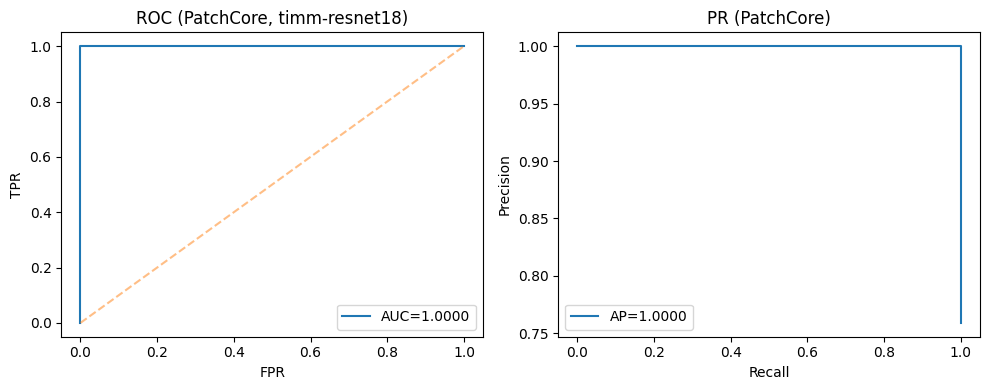

[SHOW] Top-6 anomaly candidates


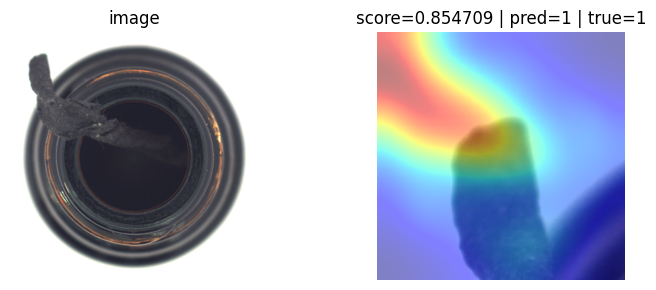

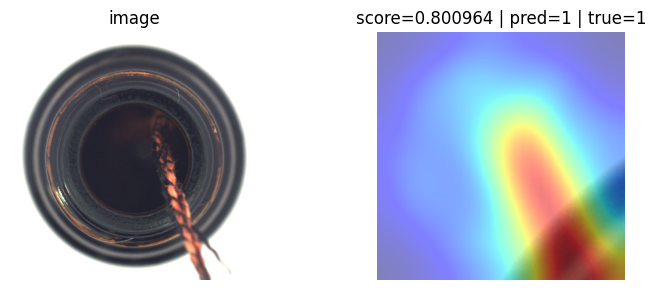

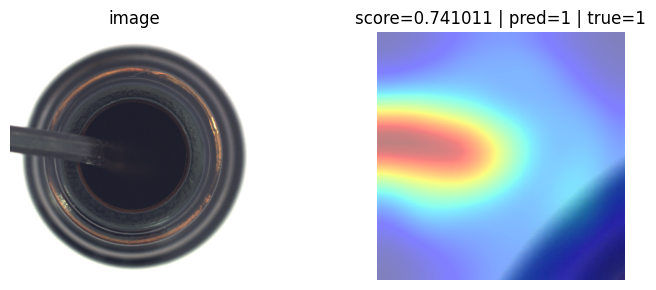

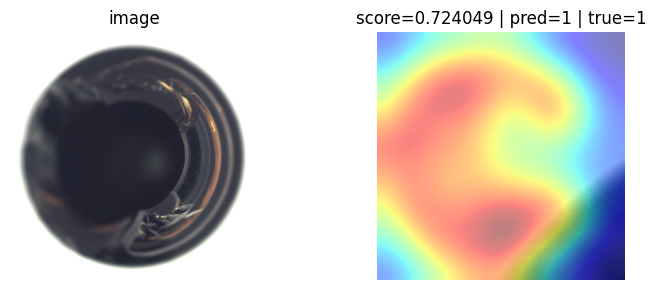

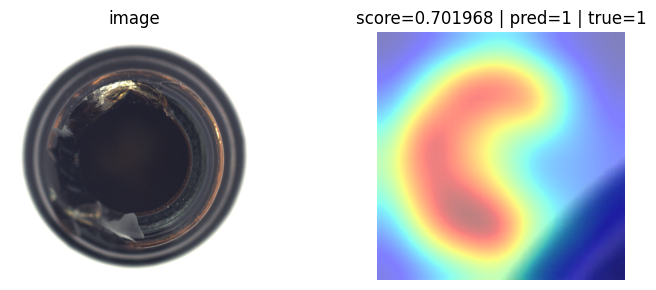

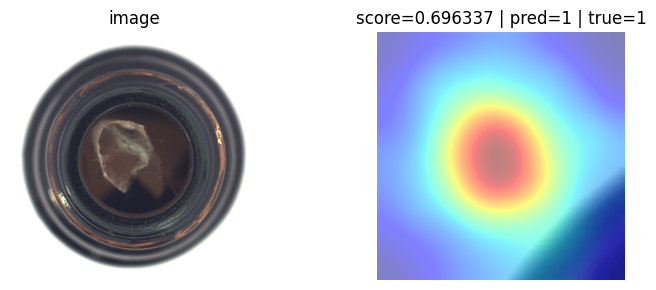

[CONF] TP=63 FP=4 FN=0 TN=16
[SHOW] False Positive examples


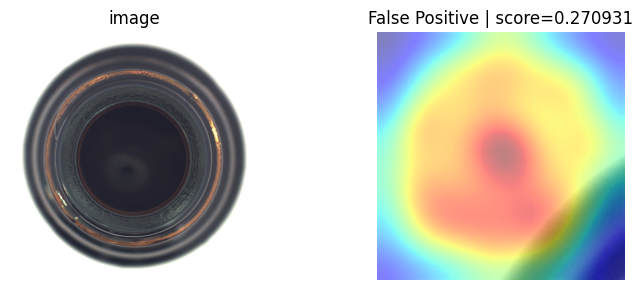

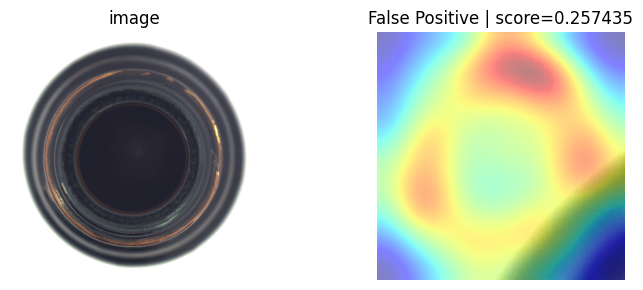

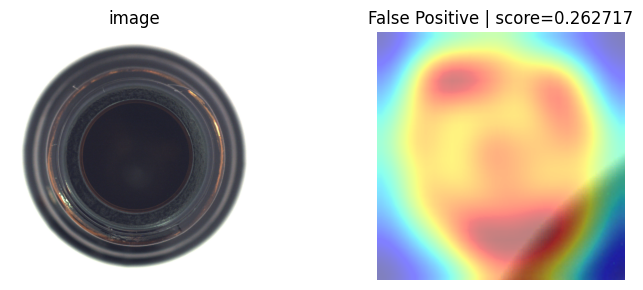

[SHOW] False Negative: none
[SAVED] /content/out_patchcore_timm/scores_bottle.npy, labels_bottle.npy


In [2]:
# ============================================================
# セル2: PatchCore (timm/ResNet18, layer2+layer3, MiniBatchKMeans coreset)
# - /content/mvtec_anomaly_detection/<class>/... を自動検出（セル1準拠）
# - 学習: 正常パッチ埋め込み → コアセット（MiniBatchKMeansで代表ベクトル）→ 1-NN 距離
# - 推論: 位置スコアマップ（距離） → 上位p%平均で画像スコア
# - 閾値: train/good を split した val の分位点
# - 可視化: ROC/PR, Top異常, 誤検出/見逃し
# ============================================================

import os, glob, math, random
from typing import List, Tuple, Dict
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# timm / sklearn が無ければ入れる
try:
    import timm
except Exception:
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "timm"], check=False)
    import timm

try:
    from sklearn.neighbors import NearestNeighbors
    from sklearn.cluster import MiniBatchKMeans
    from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
except Exception:
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "scikit-learn"], check=False)
    from sklearn.neighbors import NearestNeighbors
    from sklearn.cluster import MiniBatchKMeans
    from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

from scipy.ndimage import gaussian_filter

# ---------------- Config ----------------
CLASS_NAME       = globals().get("TARGET", "bottle")   # セル1の TARGET に合わせる
ROOT_CANDIDATES  = ["/content/mvtec", "/content/mvtec_anomaly_detection"]

IMG_SIZE         = 256
CROP_SIZE        = 224
MEAN             = [0.485, 0.456, 0.406]
STD              = [0.229, 0.224, 0.225]

BATCH            = 16
VAL_SPLIT        = 0.10
OUT_INDICES      = (2, 3)       # timm ResNet18: layer2, layer3
TOP_P            = 0.02         # 画像スコア＝上位p%平均
TAU_PERC         = 99.5         # val分布の分位点
BLUR_SIGMA       = 2.0          # ヒートマップ平滑化 (0/None で無効)

# PatchCore: コアセット
MAX_CANDIDATES   = 80000        # 事前ランダム間引き（候補の上限）
CORESET_SIZE     = 10000        # 代表ベクトル数（≒メモリバンク）
KMEANS_BATCH     = 2048         # MiniBatchKMeans のバッチサイズ

SAVE_DIR         = "/content/out_patchcore_timm"
SEED             = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(SAVE_DIR, exist_ok=True)
np.random.seed(SEED); random.seed(SEED); torch.manual_seed(SEED)
torch.set_grad_enabled(False)

# ---------------- Utility ----------------
IMG_EXTS = (".png",".jpg",".jpeg",".bmp",".tif",".tiff")
def list_images_multi_ext(dirp):
    files=[]
    for r,_,fs in os.walk(dirp):
        for f in fs:
            if os.path.splitext(f)[1].lower() in IMG_EXTS:
                files.append(os.path.join(r,f))
    return sorted(files)

def autodetect_root(cls: str):
    hits=[]
    for base in ROOT_CANDIDATES:
        p_tr = os.path.join(base, cls, "train", "good")
        p_te = os.path.join(base, cls, "test")
        if os.path.isdir(p_tr) and os.path.isdir(p_te):
            hits.append(base)
    if not hits:
        for base in ["/content"]:
            for p in glob.glob(os.path.join(base, "**", cls, "train", "good"), recursive=True):
                root = p.split(f"/{cls}/train/")[0]
                if os.path.isdir(os.path.join(root, cls, "test")):
                    hits.append(root)
    if not hits:
        raise FileNotFoundError(f"[ERROR] Dataset for class='{cls}' not found under /content.")
    hits = sorted(set(hits), key=lambda x: len(x))
    return hits[0]

def print_dataset_summary(root, cls):
    tg  = os.path.join(root, cls, "train", "good")
    ttg = os.path.join(root, cls, "test", "good")
    tdir= os.path.join(root, cls, "test")
    def _c(p): return len(list_images_multi_ext(p)) if os.path.isdir(p) else 0
    subs=[]
    if os.path.isdir(tdir):
        subs=[d for d in os.listdir(tdir) if os.path.isdir(os.path.join(tdir,d)) and d not in ["good","ground_truth"]]
    n_an=0
    for d in subs: n_an += _c(os.path.join(tdir,d))
    print("[SUMMARY]", {"root":root, "class":cls, "train/good":_c(tg),
                        "test/good":_c(ttg), "test/anoms":n_an, "anomaly_types":subs})

# ---------------- Datasets ----------------
_tf = transforms.Compose([
    transforms.Resize(IMG_SIZE, interpolation=Image.BILINEAR),
    transforms.CenterCrop(CROP_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

class MVTecTrain(Dataset):
    def __init__(self, root, cls, val_split=0.1, is_val=False):
        base = os.path.join(root, cls, "train", "good")
        files = list_images_multi_ext(base)
        assert len(files)>0, f"No train images in {base}"
        n_val = max(1, int(len(files)*val_split))
        self.files = files[:n_val] if is_val else files[n_val:]
        if is_val and len(self.files)==0: self.files = files[-n_val:]
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        img = Image.open(self.files[i]).convert("RGB")
        return _tf(img), 0

class MVTecTest(Dataset):
    def __init__(self, root, cls):
        base = os.path.join(root, cls, "test")
        goods = list_images_multi_ext(os.path.join(base, "good"))
        anoms, types = [], []
        for d in os.listdir(base):
            p = os.path.join(base, d)
            if os.path.isdir(p) and d not in ["good","ground_truth"]:
                fs = list_images_multi_ext(p)
                anoms.extend(fs); types.extend([d]*len(fs))
        self.files  = goods + anoms
        self.labels = [0]*len(goods) + [1]*len(anoms)
        self.types  = ["good"]*len(goods) + types
        assert len(self.files)>0, f"No test images in {base}"
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        img = Image.open(self.files[i]).convert("RGB")
        x = _tf(img)
        return x, self.labels[i], self.files[i], self.types[i]

# ---------------- Backbone (timm ResNet18) ----------------
backbone = timm.create_model(
    'resnet18.a1_in1k', pretrained=True, features_only=True, out_indices=OUT_INDICES
).to(device).eval()

def extract_feats(x: torch.Tensor) -> torch.Tensor:
    """
    x: (B,3,H,W) → list[ (B,C_i,H_i,W_i) ]  (layer2, layer3)
    layer3 を layer2 の空間解像度に upsample → チャネル連結 → L2正規化
    返り: (B, C_total, Ht, Wt)
    """
    feats = backbone(x)
    f2, f3 = feats[0], feats[1]         # e.g., (B,128,28,28), (B,256,14,14)
    f3u = F.interpolate(f3, size=f2.shape[2:], mode='bilinear', align_corners=False)
    f = torch.cat([f2, f3u], dim=1)     # (B,384,28,28)
    f = F.normalize(f, p=2, dim=1)
    return f

def fmap_to_desc(f: torch.Tensor) -> torch.Tensor:
    # (B,C,H,W) → (B*P, C)
    B,C,H,W = f.shape
    return f.permute(0,2,3,1).contiguous().view(B*H*W, C)

# ---------------- Dataset/Loader 準備 ----------------
root = autodetect_root(CLASS_NAME)
print_dataset_summary(root, CLASS_NAME)

ds_tr = MVTecTrain(root, CLASS_NAME, val_split=VAL_SPLIT, is_val=False)
ds_va = MVTecTrain(root, CLASS_NAME, val_split=VAL_SPLIT, is_val=True)
ds_te = MVTecTest (root, CLASS_NAME)

dl_tr = DataLoader(ds_tr, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
dl_va = DataLoader(ds_va, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
dl_te = DataLoader(ds_te, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

print(f"[INFO] train={len(ds_tr)} | val={len(ds_va)} | test={len(ds_te)}")

# ---------------- PatchCore: メモリバンク（コアセット）構築 ----------------
# 1) train/good のパッチ記述子を収集
train_desc_list = []
for xb, _ in dl_tr:
    xb = xb.to(device)
    fmap = extract_feats(xb)                # (B,Ct,Ht,Wt)
    desc = fmap_to_desc(fmap).detach().cpu()# (B*P,Ct)
    train_desc_list.append(desc)
ALL = torch.cat(train_desc_list, dim=0).numpy().astype(np.float32)  # (N_all, Ct)
N_all, Ct = ALL.shape
print(f"[PATCHES] collected: {N_all} x {Ct}")

# 2) 候補をランダム間引き → MiniBatchKMeansでコアセット（代表ベクトル）を作成
if N_all > MAX_CANDIDATES:
    idx = np.random.RandomState(SEED).permutation(N_all)[:MAX_CANDIDATES]
    CANDS = ALL[idx]
else:
    CANDS = ALL
n_clusters = int(min(len(CANDS), CORESET_SIZE))
print(f"[CORESET] candidates={len(CANDS)} → clusters={n_clusters}")

kmeans = MiniBatchKMeans(
    n_clusters=n_clusters, batch_size=KMEANS_BATCH,
    init="k-means++", max_no_improvement=20, n_init="auto", random_state=SEED,
    reassignment_ratio=0.01, verbose=0
)
kmeans.fit(CANDS)
MEM = kmeans.cluster_centers_.astype(np.float32)  # (n_clusters, Ct)
print(f"[MEM] centers: {MEM.shape}")

# 3) 1-NN 検索器
nn_index = NearestNeighbors(n_neighbors=1, algorithm="brute", metric="euclidean")
nn_index.fit(MEM)

# ---------------- スコア計算（位置マップ & 画像スコア） ----------------
def batch_patchcore_scores(xb: torch.Tensor) -> Tuple[np.ndarray, np.ndarray]:
    """
    xb: (B,3,H,W)
    返り:
      amap_up: (B, CROP_SIZE, CROP_SIZE) 位置スコア（1-NN距離）
      img_sc : (B,) 上位TOP_P%平均の画像スコア
    """
    fmap = extract_feats(xb)                    # (B,Ct,Ht,Wt)
    B, Ct, Ht, Wt = fmap.shape
    desc = fmap_to_desc(fmap).cpu().numpy().astype(np.float32)  # (B*P, Ct)
    dists, _ = nn_index.kneighbors(desc, n_neighbors=1, return_distance=True)  # (B*P,1)
    amap = dists.reshape(B, Ht, Wt)

    # 平滑化 → 画像サイズに拡大
    if BLUR_SIGMA and BLUR_SIGMA>0:
        amap = np.stack([gaussian_filter(a, sigma=BLUR_SIGMA) for a in amap], axis=0)
    amap_t = torch.from_numpy(amap).unsqueeze(1).float()
    amap_up = F.interpolate(amap_t, size=(CROP_SIZE, CROP_SIZE), mode='bilinear', align_corners=False).squeeze(1).numpy()

    # 画像スコア（上位p%平均）
    flat = amap_up.reshape(B, -1)
    k = max(1, int(flat.shape[1] * TOP_P))
    img_sc = np.array([np.mean(np.partition(flat[i], -k)[-k:]) for i in range(B)], dtype=np.float32)
    return amap_up, img_sc

# ---------------- 閾値（val） ----------------
val_scores = []
for xb, _ in dl_va:
    xb = xb.to(device)
    amap_up, sc = batch_patchcore_scores(xb)
    val_scores.extend(sc.tolist())
val_scores = np.asarray(val_scores, dtype=np.float32)
tau = float(np.percentile(val_scores, TAU_PERC))
print(f"[TAU] from val {TAU_PERC}% → tau={tau:.6f}")

# ---------------- Test 推論＆評価 ----------------
all_scores, all_labels, all_amaps, all_paths, all_types = [], [], [], [], []
for xb, yb, paths, types in dl_te:
    xb = xb.to(device)
    amap_up, sc = batch_patchcore_scores(xb)
    all_scores.extend(sc.tolist())
    all_labels.extend(yb.numpy().tolist())
    all_paths.extend(list(paths))
    all_types.extend(list(types))
    all_amaps.extend([a for a in amap_up])

scores_np = np.asarray(all_scores, dtype=np.float32)
labels_np = np.asarray(all_labels, dtype=np.int32)

auroc_img = roc_auc_score(labels_np, scores_np)
prec, rec, _ = precision_recall_curve(labels_np, scores_np)
ap_img = average_precision_score(labels_np, scores_np)
print(f"[IMAGE] AUROC={auroc_img:.4f} | AP={ap_img:.4f}")

# 曲線表示
fpr, tpr, thr = roc_curve(labels_np, scores_np)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(fpr,tpr,label=f"AUC={auroc_img:.4f}"); plt.plot([0,1],[0,1],'--',alpha=0.5)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (PatchCore, timm-resnet18)"); plt.legend()
plt.subplot(1,2,2); plt.plot(rec,prec,label=f"AP={ap_img:.4f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR (PatchCore)"); plt.legend()
plt.tight_layout(); plt.show()

# ---------------- 可視化 ----------------
def imread_rgb(p):
    img = Image.open(p).convert("RGB")
    return np.array(img)

def overlay_show(img_rgb, amap, title, alpha=0.5):
    a = amap
    if a.max() > 0:
        a = (a - a.min()) / (a.max() - a.min() + 1e-8)
    plt.figure(figsize=(8,3))
    ax1 = plt.subplot(1,2,1); ax1.imshow(img_rgb); ax1.set_title("image"); ax1.axis("off")
    ax2 = plt.subplot(1,2,2); ax2.imshow(img_rgb); ax2.imshow(a, cmap="jet", alpha=alpha); ax2.set_title(title); ax2.axis("off")
    plt.tight_layout(); plt.show()

# Top-K 異常
order = np.argsort(-scores_np)
TOPK  = min(6, len(order))
print(f"[SHOW] Top-{TOPK} anomaly candidates")
for r in range(TOPK):
    i = int(order[r])
    img = imread_rgb(all_paths[i])
    overlay_show(img, all_amaps[i], f"score={scores_np[i]:.6f} | pred={int(scores_np[i]>tau)} | true={labels_np[i]}")

# しきい値で混同行列風の枚数
preds = (scores_np > tau).astype(np.int32)
TP = np.where((preds==1)&(labels_np==1))[0]
FP = np.where((preds==1)&(labels_np==0))[0]
FN = np.where((preds==0)&(labels_np==1))[0]
print(f"[CONF] TP={len(TP)} FP={len(FP)} FN={len(FN)} TN={len(labels_np)-len(TP)-len(FN)-len(FP)}")

# 誤検出/見逃し 例
def show_examples(idxs, title):
    if len(idxs)==0:
        print(f"[SHOW] {title}: none"); return
    print(f"[SHOW] {title} examples")
    for i in idxs[:3]:
        img = imread_rgb(all_paths[i])
        overlay_show(img, all_amaps[i], f"{title} | score={scores_np[i]:.6f}")

show_examples(FP, "False Positive")
show_examples(FN, "False Negative")

# ---------------- 保存 ----------------
np.save(os.path.join(SAVE_DIR, f"scores_{CLASS_NAME}.npy"), scores_np)
np.save(os.path.join(SAVE_DIR, f"labels_{CLASS_NAME}.npy"), labels_np)
print(f"[SAVED] {SAVE_DIR}/scores_{CLASS_NAME}.npy, labels_{CLASS_NAME}.npy")
